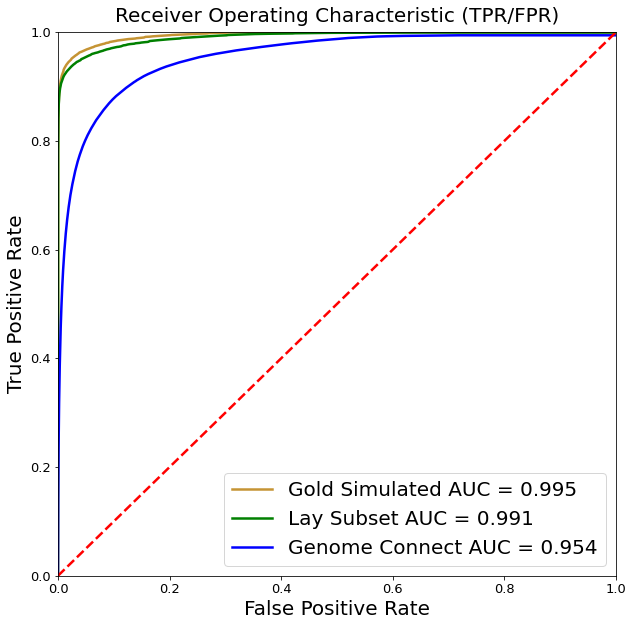

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from pathlib import Path
import gzip
from typing import Tuple, List


annotation_file = '../data/synthetic/gold-standard.tsv.gz'

classes = set()
with gzip.open(annotation_file, 'rt') as annot_file:
    for line in annot_file:
        row = line.rstrip().split('\t')
        classes.add(row[0])

n_classes = len(classes)


def get_tpr_fpr(file) -> Tuple[List[int], List[int]]:
    
    fpr = { disease: [] for disease in classes }
    tpr = { disease: [] for disease in classes }

    # iterate over confusion matrix and calculate per disease
    with gzip.open(file, 'rt') as confusion_file:
        for line in confusion_file:
            disease, score, true_pos, false_pos, false_neg, true_neg = line.rstrip().split('\t')
            fpr[disease].append(int(false_pos) / (int(false_pos) + int(true_neg)))
            try:
                tpr[disease].append( int(true_pos) / (int(true_pos) + int(false_neg)) )
            except ZeroDivisionError:
                # Some diseases were removed from GC and lay if no phenotypes could be simulated
                tpr[disease].append(0)

    micro_fpr = [sum(x) / len(x) for x in zip(*fpr.values())]
    micro_tpr = [sum(x) / len(x) for x in zip(*tpr.values())]
    return micro_fpr, micro_tpr


gc_confusion = '../data/confusion_matrices/phenodigm/gc-confusion.tsv.gz'
gold_confusion = '../data/confusion_matrices/phenodigm/gold-confusion.tsv.gz'
lay_confusion = '../data/confusion_matrices/phenodigm/lay-confusion.tsv.gz'

sim_fpr, sim_tpr = get_tpr_fpr(gold_confusion)
gc_fpr, gc_tpr = get_tpr_fpr(gc_confusion)
lay_fpr, lay_tpr = get_tpr_fpr(lay_confusion)


sim_auc = auc(sim_fpr, sim_tpr)
gc_auc = auc(gc_fpr, gc_tpr)
lay_auc = auc(lay_fpr, lay_tpr)

line_width = 2.5

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic (TPR/FPR)', fontsize=20, pad=10)
plt.plot(sim_fpr, sim_tpr, '#C59434', label = 'Gold Simulated AUC = %0.3f' % sim_auc, linewidth=line_width)
plt.plot(lay_fpr, lay_tpr, 'g', label = 'Lay Subset AUC = %0.3f' % lay_auc, linewidth=line_width)
plt.plot(gc_fpr, gc_tpr, 'b', label = 'Genome Connect AUC = %0.3f' % gc_auc, linewidth=line_width)
#plt.plot(gold_fpr, gold_tpr, 'b', label = 'Gold Standard AUC = %0.3f' % gold_auc, linewidth=7.0)

plt.legend(loc = 'lower right', prop={'size': 20})
plt.plot([0, 1], [0, 1],'r--', linewidth=line_width)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=20)
plt.savefig('./roc-curve.png', bbox_inches = 'tight', pad_inches = 0)
plt.show()
